# 0. Set-up

In [1]:
import os
import re
import sys
import pickle
import importlib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter

import osmnx as ox 
import networkx as nx
from pyproj import Transformer
from shapely.geometry import Point, Polygon, LineString

from igraph import Graph
import igraph as iG
import time

import traceback
from rtree import index
from multiprocessing import Pool, cpu_count

import plotly as py
import plotly.graph_objs as go

def reload_module(module):
    importlib.reload(module)

# Specify the directory containing the .py modules
module_dir = "../modules"

# Add the directory to the Python path
sys.path.append(os.path.abspath(module_dir))

def value_formatter(x, pos=None):
    # Format with commas as thousand separators
    return f"{abs(int(x)):,}" if x == int(x) else f"{abs(x):,.2f}"

# 1. Load Knowledge Base & Map Resources

In [2]:
import datasets_v2

reload_module(datasets_v2)
from datasets_v2 import KnowledgeBase

import map_resources_v2

reload_module(map_resources_v2)
from map_resources_v2 import MapResources

In [3]:
# A wide dataframe for PUBLIC schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_public_datasets.csv'
public = pd.read_csv(fpath, index_col='school_id')
# print(public.shape)

# A wide dataframe for PRIVATE schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_private_datasets.csv'
private = pd.read_csv(fpath, index_col='school_id')
# print(private.shape)

# Initialize class that also preloads and reorganizes PSGC shapefiles
mr = MapResources(preloaded=True)

# The gpd_gadm is the dataframe of the shapefiles of Philippines following PSGC with EPSG:4326
gpd_gadm = mr.gadm.copy()

# The output is a dictionary of complete filepaths where the keys are the PSGC region names
# of our 17 regions. These are OSMNX drive graph networks
mr.get_filepaths_of_regional_road_networks()

# Additional preprocessing is done on our compiled public & private datasets
gdf_public = mr.preprocess_public_school_coordinates_further(public)
gdf_private = mr.preprocess_private_school_coordinates_further(private)

# 2. Build School Networks
* * *
We will use our `optimized_network_builder` module to facilitate the preparation and generation of the graph network of our schools using our compiled knowledge base and organized shapefiles. We provide a high-level overview below of how the project generates a graph network of schools.

<dl>
    Given the PSGC code of a target region:
    <ol type="1">
      <li>We get the shapefiles/geographies of the target region and its adjacent localities</li>
      <li>Using the above shapefiles, we extract the public schools in the target region and extract private schools that fall within the target and adjacent areas</li>
      <li>Still using the shapefiles, we cutout the drive network from our preloaded & locally saved OSMNX graph networks</li>
      <li>Feed the following to our network builder:
        <ol type="1">
          <li>Target & adjacent shapefiles</li>
          <li>Public and private schools</li>
          <li>Drive graph network</li>
        </ol>
      </li>
      <li>Run network builder algorithm</li>
    </ol>
</dl>

For this notebook, we demonstrate the generation of a network of schools in Region IV-A.

In [4]:
import optimized_network_builder

reload_module(optimized_network_builder)
from optimized_network_builder import OptimizedSchoolNetworkBuilder

## 2.1. Region IV-A

### 2.1.1. Extract geographies

We extract the shapes of our target geography and its adjacent geographies. `max_depth` here determines how far the algorithm will crawl outward from the target region when extracting adjacent geographies.

In [5]:
target_psgc = '0400000000' # Region IV-A
max_depth = 3
geo_results = mr.get_adjacent_geographies(
    gpd_gadm=gpd_gadm, 
    target_psgc=target_psgc, 
    max_depth=max_depth
)

Finding adjacent geographies for PSGC 0400000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
Found 62 adjacent areas at depth 1
Finding adjacent areas at depth 2...
Found 101 adjacent areas at depth 2
Finding adjacent areas at depth 3...
Found 136 adjacent areas at depth 3
Geography processing completed in 9.14 seconds


In [6]:
# We display the content of geo_results for reference
geo_results.keys()

dict_keys(['target_area', 'adjacent_areas', 'search_area_complete', 'target_shape', 'adjacent_shapes', 'search_shape_complete'])

<dl>
To provide a brief description of the contents of <strong>geo_results</strong>:
    <ol>
        <li>target_area: A GeoDataFrame containing the polygons of the target geography</li>
        <li>adjacent_areas: A dictionary whose keys are 1,2,3 (for max_depth of 3) whose values are GeoDataFrames containing the polygons of the adjacent geographies to the target</li>
        <li>search_area_complete: A GeoDataFrame containing the polygons of the target and adjacent geographies</li>
        <li>target_shape, adjacent_shapes, & search_shape_complete: A .unary_union of the above GeoDataFrames</li>
    </ol>
</dl>

### 2.1.2. Extract public & private schools

In [7]:
%%time
# Extracting schools using extracted geographies
school_results = mr.extract_schools_from_geographies(
    geography_results=geo_results,
    gdf_public=gdf_public,
    gdf_private=gdf_private
)

Extracting schools from geographies...
Extracting public schools...
Found 3548 public schools in target area
Found 118 public schools in adjacent areas at depth 1
Found 174 public schools in adjacent areas at depth 2
Found 203 public schools in adjacent areas at depth 3
Extracting private schools...
Found 2653 private schools in the entire search area
School extraction completed in 891.53 seconds
CPU times: user 14min 51s, sys: 55.8 ms, total: 14min 51s
Wall time: 14min 51s


In [8]:
# We display the content of geo_results for reference
school_results.keys()

dict_keys(['public_schools_in_target', 'public_schools_in_adjacent', 'private_schools_all'])

We plot our search area along with our extracted public and private schools to inspect if we, more or less, captured what we need in our target region.

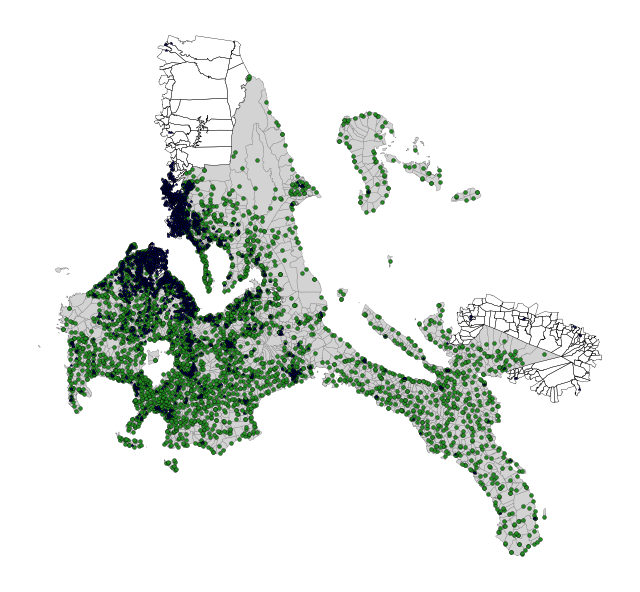

CPU times: user 2.72 s, sys: 150 ms, total: 2.87 s
Wall time: 2.68 s


In [9]:
%%time
fig, ax = plt.subplots(figsize=(8,8))

geo_results['target_area'].plot(
    ax=ax, facecolor='lightgrey', edgecolor='gray',
    linewidth=.25
)
for k, v in geo_results['adjacent_areas'].items():
    df_adj = geo_results['adjacent_areas'].get(k)
    df_adj.plot(
        ax=ax, facecolor='none', edgecolor='black',
        linewidth=.25
    )

school_results['public_schools_in_target'].plot(
    ax=ax, facecolor='forestgreen',
    edgecolor='black', linewidth=.25,
    marker='.', markersize=30
)
school_results['private_schools_all'].plot(
    ax=ax, facecolor='navy',
    edgecolor='black', linewidth=.25,
    marker='*', markersize=5
)

ax.axis('off')

plt.show()

### 2.1.3. Extract drive graph network

In [10]:
# We cull a subgraph from locally saved regional drive graph networks
G_sub = mr.generate_subgraph(geo_results)

Generating subgraph from geo_results
Subgraph extracted. Time elapsed: 2.63 minutes


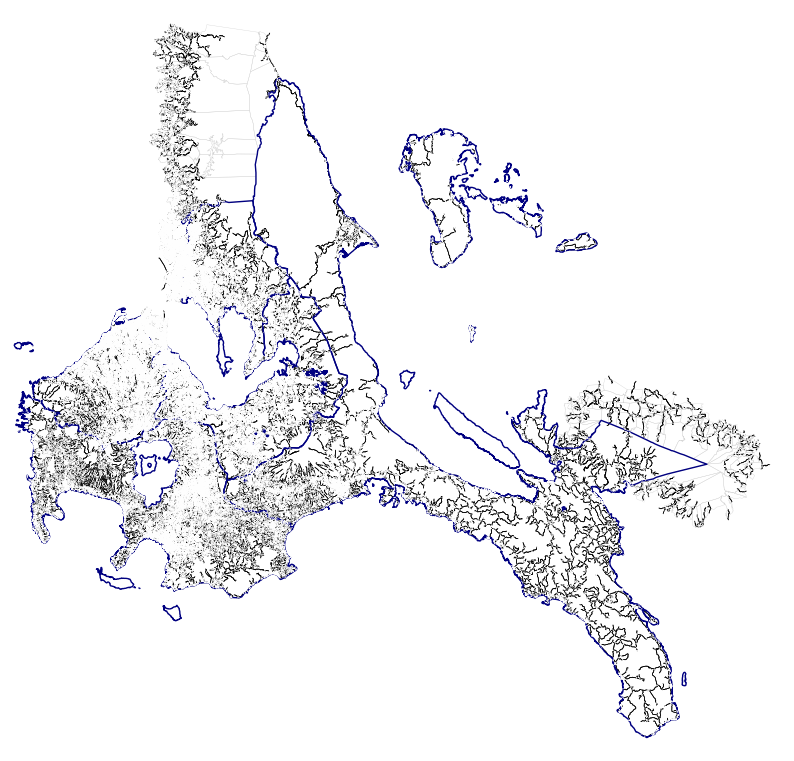

CPU times: user 56.2 s, sys: 610 ms, total: 56.8 s
Wall time: 56.6 s


In [11]:
%%time
# For sanity, we plot our geographies, schools, and subgraph road network
fig, ax = ox.plot_graph(
    G_sub, figsize=(10,10),
    node_size=.5, edge_linewidth=.5,
    bgcolor='none', show=False, close=False,
    node_zorder=4, edge_color='black',
)

geo_results['target_area'].dissolve(by='adm2_psgc').plot(
    ax=ax, facecolor='none', edgecolor='navy',
    linewidth=1, alpha=1, zorder=3
)

df_adjs = []
for k, v in geo_results['adjacent_areas'].items():
    df_adj = geo_results['adjacent_areas'].get(k)
    df_adj.plot(
        ax=ax, facecolor='none', edgecolor='lightgrey',
        linewidth=.25, zorder=2
    )
    df_adjs.append(df_adj)
df_adjs = pd.concat(df_adjs)

plt.show()

### 2.1.4. Build network

In [12]:
# We explicitly identify the major groups that will comprise the school network
# This will be removed in the future since we will connect schools with each other regardless of groups
public_in_city = school_results['public_schools_in_target'].copy()

# My private dataframe has columns with "validated" coordinates - we explicitly call them here
private_in_space = school_results['private_schools_all'].copy()
private_in_space = private_in_space.drop(columns=['longitude','latitude'])
private_in_space = private_in_space.rename(
    columns={'longitude_valid':'longitude', 'latitude_valid':'latitude'}
)

adjacent_dfs = [v for k,v in school_results['public_schools_in_adjacent'].items()]
public_periph = pd.concat(adjacent_dfs)

In [13]:
# Initialize the optimized builder
network_builder = OptimizedSchoolNetworkBuilder(
    road_network_graph=G_sub,
    public_schools_gdf=public_in_city.reset_index(),
    private_schools_gdf=private_in_space.reset_index(),
    peripheral_schools_gdf=public_periph.reset_index(),
    admin_boundary=geo_results['target_area']
)

In [19]:
# %%time
# # Build the complete network in one call
# results = network_builder.build_complete_network(
#     buffer_distance_m=5000,
#     max_distance_km=15
# )

🚀 Starting optimized network build...
📊 Setting up master infrastructure...
School counts: Public=3548, Private=2653, Peripheral=495
Combined 6696 total schools
🔄 Converting NetworkX to iGraph...
Projected graph: 380100 nodes, 985152 edges
Created iGraph with 380100 vertices and 985152 edges
🔄 Creating WGS84 version of master iGraph...
Created iGraph with 380100 vertices and 985152 edges
Created 4326 iGraph with 380100 vertices
🗺️  Mapping schools to road network vertices...
Mapping results: 6696 successful, 0 failed
✅ Master graph: 380100 vertices, 985152 edges
✅ Master graph 4326: 380100 vertices
✅ Mapped 6696 schools to road network
🌍 Building spatial indices...
✅ Built spatial indices for 3 school types

🐛 DEBUG: Testing single school...
Testing school ID: 107329
✅ School 107329 mapped to vertex 331832
Found 10 nearby schools: [107318, 107329, 107334, 107319, 342211]...
Calculating distances from 107329 to 5 unique destinations
Distance calculation successful: (1, 5)
Distance matri

Total runtime: 3h 1min 2s

We save the network of schools that we generated (found in the dictionary object `results`) in a pickle file so we do not have to rerun the network builder algorithm when we compute network statistics in the future.

In [20]:
save_path = '../output/gnet_Region4A_06-22-2025.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(results, file)

We then load the pickle file and display the contents of `results`.

In [6]:
load_path = '../output/gnet_Region4A_06-22-2025.pkl'
with open(load_path, 'rb') as file: # Open the file in binary read mode ('rb')
    results = pickle.load(file) # Load the dictionary from the file

print(results.keys())

dict_keys(['distance_matrix', 'routes', 'master_graph', 'master_graph_4326', 'school_mappings', 'pruned_graph'])


In [ ]:
# %matplotlib inline
# # Sanity check if we capture our schools in Rizal
# fig, ax = plt.subplots(figsize=(10,10))

# mult_savefig = 1
# # Plot network anchored on the schools' lon-lat
# iG.plot(
#     results['pruned_graph'],
#     target=ax, # **visual_style,
#     vertex_size=2*mult_savefig,
#     vertex_frame_width=.1,
#     edge_width=.1,           # Make edges thicker
#     edge_arrow_size=2*mult_savefig,      # Control arrow size
#     edge_arrow_width=2*mult_savefig,     # Control arrow width
#     bbox=(1000,1000),
#     margin=0
# )

# geo_results['target_area'].to_crs(3123).plot(
#     ax=ax, facecolor='none', edgecolor='navy',
#     linewidth=.25, alpha=1,
# )

# df_adjs = []
# for k, v in geo_results['adjacent_areas'].items():
#     df_adj = geo_results['adjacent_areas'].get(k)
#     df_adj.to_crs(3123).plot(
#         ax=ax, facecolor='lightgray', edgecolor='grey',
#         linewidth=.25, alpha=.1
#     )
#     df_adjs.append(df_adj.to_crs(3123))
# df_adjs = pd.concat(df_adjs)

# df_cm = geo_results['target_area'].to_crs(3123).copy()
# cm_3123_shp = df_cm.unary_union # This is 4326

# min_x, min_y, max_x, max_y = cm_3123_shp.bounds
# multiplier = 0.01
# ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
# ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

# # plt.savefig(
# #     '../output/up_pascn/rizal_network_general.png',
# #     dpi=400, transparent=True, bbox_inches ='tight',
# # )

# plt.show()

1. ECAIR version of suggested ESC and SHSVP subsidy amount
2. Absorptive Cap of ESC grantees and SHSVP per private schools 
3. How many public junior high schools are on shifting sched and congested? 
4. How many ESC vouchers are needed per region?
5. How many are excess learners in public elementary and JHS schools with regard to the absorptive, seats, rooms?
6. How many public elem grad can avail the top up amount once qualified in the ESC program? Same question for SHSVP

In [7]:
g = results['pruned_graph']
get_attrs = lambda node: node['school_attrs'][0]

In [8]:
cocs = list(set([get_attrs(node)['modified coc'] for node in g.vs]))
print(cocs)

['JHS with SHS', 'Purely ES', 'Purely SHS', 'Purely JHS', nan, 'All Offering', 'ES and JHS']


In [9]:
es_schools_idxs = []
jhs_schools_idxs = []

for node in g.vs:
    node_idx = node.index
    coc = get_attrs(node)['modified coc']
    sector = get_attrs(node)['sector']

    if sector == 'Public' and coc in ['All Offering','ES and JHS','Purely ES']:
        es_schools_idxs.append(node_idx)

    if coc in ['All Offering', 'JHS with SHS', 'Purely JHS', 'ES and JHS']:
        jhs_schools_idxs.append(node_idx)

print(len(es_schools_idxs))
print(len(jhs_schools_idxs))

2740
1967


In [10]:
valid_edges = []
max_dist = 5_000

# Dataframe data
df_data = []

for edge in g.es:
    source, target = edge.tuple
    edge_dist = edge['length']

    if (source in es_schools_idxs or source in jhs_schools_idxs) \
    or (target in jhs_schools_idxs):

        if edge['length'] <= max_dist:
            valid_edges.append(edge.index)

            src_node, trg_node = g.vs[source], g.vs[target]
            src_attrs, trg_attrs = get_attrs(src_node), get_attrs(trg_node)

            row_data = []
            if trg_attrs['sector'] == 'Private' and trg_attrs['esc_participating'] == 1:
                val_array = [
                    src_node['school_id'],
                    src_attrs['region'],
                    trg_node['school_id'],
                    trg_attrs['region'],
                    trg_attrs['esc_amount'],
                    trg_attrs['esc_(total)'],
                ]
                row_data.extend(val_array)
                df_data.append(row_data)
# print(len(valid_edges))

subgraph1_esc = g.subgraph_edges(valid_edges, delete_vertices=False)

In [11]:
# [node for node in subgraph1_esc.vs if get_attrs(node)['sector'] == 'Private'][0]

In [12]:
eda_esc = pd.DataFrame(
    data=df_data,
    columns=[
        'origin_school_id',
        'origin_region',
        'target_school_id',
        'target_region',
        'target_esc_amount',
        'target_tuition_total',
    ]
)
display(eda_esc.head(3))

,origin_school_id,origin_region,target_school_id,target_region,target_esc_amount,target_tuition_total
0,107329,Region IV-A,401582,Region IV-A,9000.0,22845.5
1,107329,Region IV-A,401581,Region IV-A,9000.0,15500.0
2,107334,Region IV-A,401582,Region IV-A,9000.0,22845.5


In [13]:
eda_esc['target_tuition_total'].describe()

count     12522.000000
mean      35367.681394
std       17271.967381
min        9000.000000
25%       24600.000000
50%       32838.000000
75%       41765.000000
max      153665.000000
Name: target_tuition_total, dtype: float64

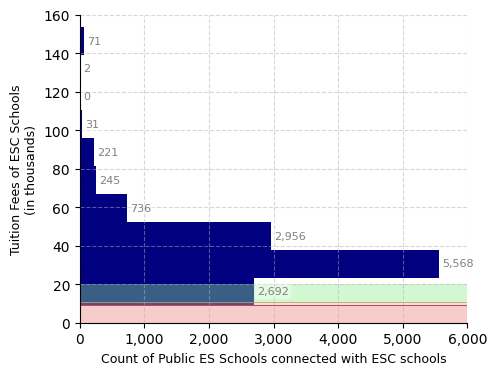

In [108]:
fig, ax = plt.subplots(figsize=(5,4))

n, bins, patches = ax.hist(
    eda_esc['target_tuition_total'], label='Region IV-A',
    zorder=1, color='navy', bins=10,
    orientation='horizontal',
)

def in_thousands(x, pos=0):
    x_label = x / 1e3
    return f"{x_label:,.0f}"
ax.yaxis.set_major_formatter(in_thousands)

ax.xaxis.set_major_formatter(value_formatter)

ax.set_title('')
ax.set_ylabel('Tuition Fees of ESC Schools\n(in thousands)', size=9)
ax.set_xlabel('Count of Public ES Schools connected with ESC schools', size=9)
ax.spines[['top','right']].set_visible(False)

ax.grid(axis='both', linestyle='--', alpha=.5, zorder=2)

for i, patch in enumerate(patches):
    # For horizontal bars:
    # patch.get_width() gives the length of the bar (the count)
    # patch.get_y() gives the bottom edge of the bar
    # patch.get_height() gives the thickness of the bar
    
    # Text position:
    # x-coordinate: just beyond the end of the bar (patch.get_width())
    # y-coordinate: center of the bar (patch.get_y() + patch.get_height() / 2)
    
    # The label text will be the count (n[i])
    ax.text(
        patch.get_width()+50,  # x position of the text
        patch.get_y() + patch.get_height() / 2, # y position (center of the bar)
        f'{int(n[i]):,.0f}',  # The actual count as text
        ha='left',      # Horizontal alignment: 'left' aligns text to the left of the x-coordinate
        va='center',    # Vertical alignment: 'center' centers text vertically with the y-coordinate
        color='grey',
        fontsize=8,
        # A small offset to prevent text from overlapping the bar
        # Adjust as needed based on your plot's scale
        bbox=dict(facecolor='white', alpha=0.4, edgecolor='none', pad=1.5) # Optional: adds a background for readability
    )

ax.axhline(y=11_000, xmax=ax.get_xlim()[1], color='salmon', alpha=.8, linewidth=.75)
ax.axhline(y=9_000, xmax=ax.get_xlim()[1], color='crimson', alpha=.8, linewidth=.75)

ax.fill_between(
    x=(ax.get_xlim()[0], 6_000),
    y1=9_000, y2=20_000,
    facecolor='lightgreen',
    alpha=0.4,
    label='Filled Area'
)
ax.fill_between(
    x=(ax.get_xlim()[0], 6_000),
    y1=0, y2=9_000,
    facecolor='lightcoral',
    alpha=0.4,
    label='Filled Area'
)
ax.set_xlim(0,6_000)
ax.set_ylim(0,160_000)

# plt.yscale('log')

plt.show()
plt.close()

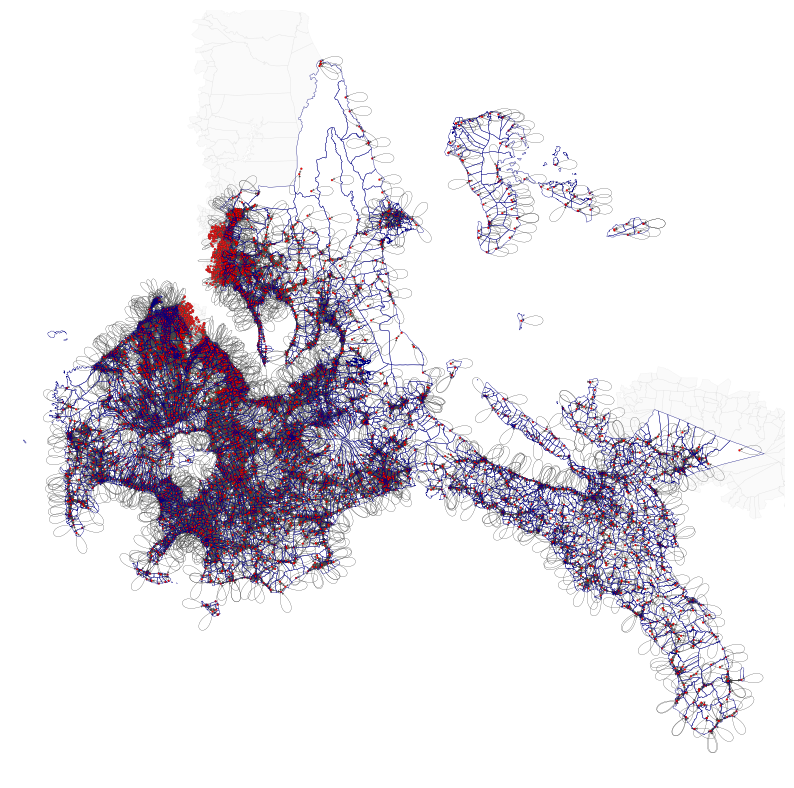

In [19]:
# fig, ax = plt.subplots(figsize=(10,10))

# mult_savefig = 1
# # Plot network anchored on the schools' lon-lat
# iG.plot(
#     subgraph1_esc,
#     target=ax, # **visual_style,
#     vertex_size=2*mult_savefig,
#     vertex_frame_width=.1,
#     edge_width=.1,           # Make edges thicker
#     edge_arrow_size=2*mult_savefig,      # Control arrow size
#     edge_arrow_width=2*mult_savefig,     # Control arrow width
#     bbox=(1000,1000),
#     margin=0
# )

# geo_results['target_area'].to_crs(3123).plot(
#     ax=ax, facecolor='none', edgecolor='navy',
#     linewidth=.25, alpha=1,
# )

# df_adjs = []
# for k, v in geo_results['adjacent_areas'].items():
#     df_adj = geo_results['adjacent_areas'].get(k)
#     df_adj.to_crs(3123).plot(
#         ax=ax, facecolor='lightgray', edgecolor='grey',
#         linewidth=.25, alpha=.1
#     )
#     df_adjs.append(df_adj.to_crs(3123))
# df_adjs = pd.concat(df_adjs)

# df_cm = geo_results['target_area'].to_crs(3123).copy()
# cm_3123_shp = df_cm.unary_union # This is 4326

# min_x, min_y, max_x, max_y = cm_3123_shp.bounds
# multiplier = 0.01
# ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
# ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

# # plt.savefig(
# #     '../output/up_pascn/rizal_network_general.png',
# #     dpi=400, transparent=True, bbox_inches ='tight',
# # )

# plt.show()